In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Part A

In [20]:
data_original = pd.read_csv("./UCI_Credit_Card.csv")
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [21]:
print(f"Shape of the dataset : {data_original.shape}")
data_original.head(2)

Shape of the dataset : (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1


In [22]:
float_cols = data_original.select_dtypes(include=['float64']).columns

# choosing 3 float columns in random and introducing Nan values for experimentation
np.random.seed(42)
selected_columns = np.random.choice(float_cols, size=3, replace=False)
print(f"Selected columns for Experimentation: {selected_columns} \n")

# Introducing NaN values
data_new = data_original.copy()
data_new.loc[data_new.sample(frac=0.1, random_state=42).index, selected_columns] = np.nan

# Nan value counts
nan_counts = data_new[selected_columns].isna().sum()
print(f"NaN value counts in selected columns:\n{nan_counts}")

Selected columns for Experimentation: ['PAY_AMT5' 'PAY_AMT3' 'LIMIT_BAL'] 

NaN value counts in selected columns:
PAY_AMT5     3000
PAY_AMT3     3000
LIMIT_BAL    3000
dtype: int64


### imputation strategy 1

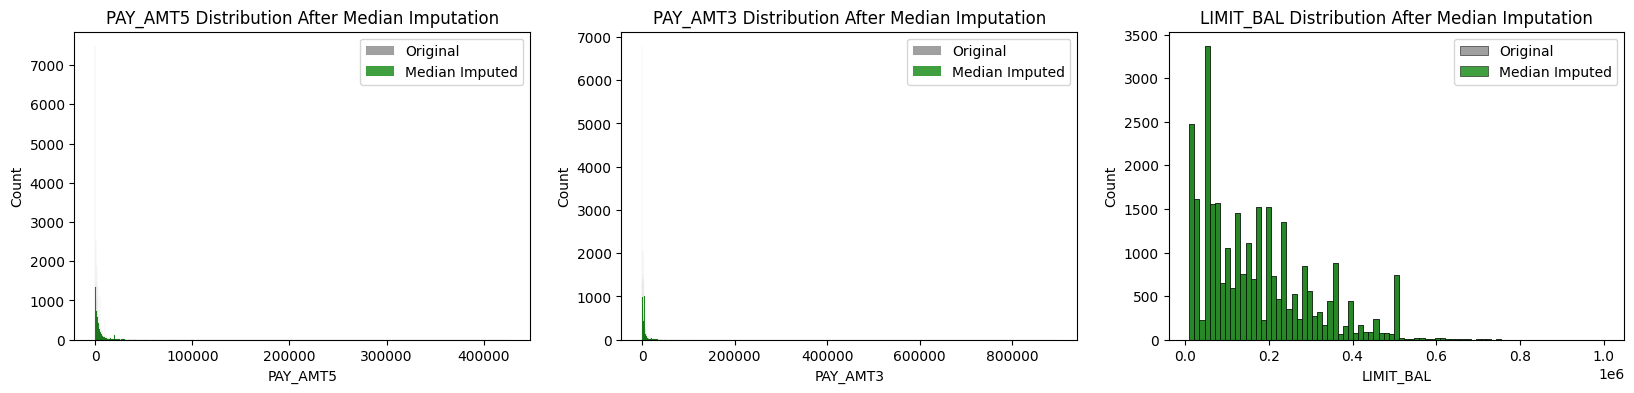

In [39]:
temp_data = data_original.copy()
for col in selected_columns:
    temp_data[col] = temp_data[col].fillna(temp_data[col].median())

# Visual Comparison
fig, axes = plt.subplots(1, 3, figsize=(20,4))
for i, col in enumerate(selected_columns):
    sns.histplot(data_original[col], label="Original", ax=axes[i], color='gray', fill=True)
    sns.histplot(temp_data[col], label="Median Imputed", ax=axes[i], color='green')
    axes[i].set_title(f"{col} Distribution After Median Imputation")
    axes[i].legend()
plt.show()

In [25]:
data_a = data_new.copy()  # Dataset A: clean copy

# find columns with missing values and restrict to numeric columns (median only makes sense for numbers)
cols_with_na = data_a.columns[data_a.isna().any()]
num_cols_with_na = data_a[cols_with_na].select_dtypes(include=[np.number]).columns

print("\n Columns with missing values:", list(cols_with_na))
print("\n Numeric columns to impute with median:", list(num_cols_with_na))

# show NaN counts before
print("\n NaN counts before imputation:\n", data_a[num_cols_with_na].isna().sum())

# median imputation
for col in num_cols_with_na:
    med = data_a[col].median()
    data_a[col] = data_a[col].fillna(med)

# verify
print("\n NaN counts after median imputation:\n", data_a[num_cols_with_na].isna().sum())


 Columns with missing values: ['LIMIT_BAL', 'PAY_AMT3', 'PAY_AMT5']

 Numeric columns to impute with median: ['LIMIT_BAL', 'PAY_AMT3', 'PAY_AMT5']

 NaN counts before imputation:
 LIMIT_BAL    3000
PAY_AMT3     3000
PAY_AMT5     3000
dtype: int64

 NaN counts after median imputation:
 LIMIT_BAL    0
PAY_AMT3     0
PAY_AMT5     0
dtype: int64


- Median is often preferred over the mean for imputation because it is robust to outliers and skewed distributions — it preserves a central tendency without being pulled by extreme values.

- With median, we can see from the histplot as well, both new and original looks almost similar and the data didn't become skewed after that

### Imputation strategy 2

In [34]:
from sklearn.linear_model import LinearRegression

# Dataset B: start from data_new (with NaNs introduced)
data_b = data_new.copy()

# identify numeric cols with NaNs and pick one target column to impute
cols_with_na = data_b.columns[data_b.isna().any()]
num_cols_with_na = data_b[cols_with_na].select_dtypes(include=[np.number]).columns
target_col = list(num_cols_with_na)[0]  # choose first numeric column with NaNs

print("\nNumeric columns with missing values:", list(num_cols_with_na))
print("\nTarget column for regression imputation:", target_col)
print("\nNaNs before imputation (target):", data_b[target_col].isna().sum())

# Restore other selected columns' NaN entries from the original dataset (Need not to remove those columns as per the mail)
# (`selected_columns` was defined earlier when introducing NaNs)
other_cols = [c for c in selected_columns if c != target_col]
for col in other_cols:
    na_mask = data_b[col].isna()
    if na_mask.any():
        data_b.loc[na_mask, col] = data_original.loc[na_mask, col]
        print(f"\n Restored {na_mask.sum()} NaN(s) in column '{col}' from data_original")

# predictors: all numeric columns except the target
predictors = list(data_b.select_dtypes(include=[np.number]).columns.drop(target_col))

# prepare training data: rows where target is present and predictors are not null
train_mask = data_b[target_col].notna() & data_b[predictors].notna().all(axis=1)
X_train = data_b.loc[train_mask, predictors]
y_train = data_b.loc[train_mask, target_col]

# rows to predict: where target is missing but predictors are available
to_pred_mask = data_b[target_col].isna() & data_b[predictors].notna().all(axis=1)
X_pred = data_b.loc[to_pred_mask, predictors]

if len(X_train) == 0:
    print("No rows available to train the regression model (predictors or target missing).")
else:
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    if len(X_pred) > 0:
        preds = lr.predict(X_pred)
        data_b.loc[X_pred.index, target_col] = preds
        print(f"\n Imputed {len(preds)} missing values in '{target_col}' using LinearRegression.")
    else:
        print("No rows with missing target and complete predictors to impute.")

print("\n NaNs after imputation (target):", data_b[target_col].isna().sum())


Numeric columns with missing values: ['LIMIT_BAL', 'PAY_AMT3', 'PAY_AMT5']

Target column for regression imputation: LIMIT_BAL

NaNs before imputation (target): 3000

 Restored 3000 NaN(s) in column 'PAY_AMT5' from data_original

 Restored 3000 NaN(s) in column 'PAY_AMT3' from data_original

 Imputed 3000 missing values in 'LIMIT_BAL' using LinearRegression.

 NaNs after imputation (target): 0


Explanation (underlying assumption — Missing At Random, 2-3 points):

- MAR assumes that, conditional on the observed variables, the probability of a value being missing does not depend on the unobserved (missing) value itself — so other observed features can explain the missingness.

- Under MAR, you can model the missing values from the observed predictors (e.g., via regression); if the missingness depends on the missing value (MNAR), regression imputation will be biased.

- This restores NaNs in the other columns from data_original so those columns keep their original values (no removal).

- Regression then uses the restored columns (and other non-missing features) to predict the target under the MAR assumption.

### Imputation method 3

In [36]:
from sklearn.ensemble import RandomForestRegressor

# Dataset C: start with new copy containing NaNs
data_c = data_new.copy()

# Use same target column as Strategy 2 for comparison
target_col = list(num_cols_with_na)[0]

print("\nTarget column for RF imputation:", target_col)
print("NaNs before imputation:", data_c[target_col].isna().sum())

# Restore other columns from original data
other_cols = [c for c in selected_columns if c != target_col]
for col in other_cols:
    na_mask = data_c[col].isna()
    if na_mask.any():
        data_c.loc[na_mask, col] = data_original.loc[na_mask, col]
        print(f"\nRestored {na_mask.sum()} NaN(s) in column '{col}' from original")

# Prepare data for Random Forest
predictors = list(data_c.select_dtypes(include=[np.number]).columns.drop(target_col))
train_mask = data_c[target_col].notna() & data_c[predictors].notna().all(axis=1)
X_train = data_c.loc[train_mask, predictors]
y_train = data_c.loc[train_mask, target_col]

to_pred_mask = data_c[target_col].isna() & data_c[predictors].notna().all(axis=1)
X_pred = data_c.loc[to_pred_mask, predictors]

# Train and predict using Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth = 20, random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_pred)
data_c.loc[X_pred.index, target_col] = preds

print("\nNaNs after RF imputation:", data_c[target_col].isna().sum())


Target column for RF imputation: LIMIT_BAL
NaNs before imputation: 3000

Restored 3000 NaN(s) in column 'PAY_AMT5' from original

Restored 3000 NaN(s) in column 'PAY_AMT3' from original

NaNs after RF imputation: 0


Explanation:

- Non-linear Relationships: Random Forest can capture complex non-linear relationships between features, potentially leading to more accurate imputations than linear regression.

- Feature Importance: Random Forest inherently handles feature importance, effectively using the most relevant predictors for imputation while being robust to irrelevant features.

- Ensemble Method: By averaging predictions from multiple decision trees, Random Forest reduces overfitting and provides more stable imputations compared to single models.

## Task 2

### Splitting dataset

In [40]:
def split_dataset(data, test_size=0.2, random_state=42):
    """
    Split a dataset into training and testing sets.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Input dataset to split
    test_size : float, default=0.2
        Proportion of data to use for testing
    random_state : int, default=42
        Random seed for reproducibility
        
    Returns:
    --------
    X_train, X_test, y_train, y_test : numpy arrays
        Split features and target variables
    """
    from sklearn.model_selection import train_test_split
    
    # Separate features and target
    X = data.drop('default.payment.next.month', axis=1)
    y = data['default.payment.next.month']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Create Dataset D using listwise deletion
data_d = data_new.dropna()

# Split all datasets
datasets = {
    'A': data_a,
    'B': data_b,
    'C': data_c,
    'D': data_d
}

# Dictionary to store split datasets
split_datasets = {}

# Split each dataset
for name, data in datasets.items():
    split_datasets[name] = split_dataset(data)
    print(f"\nDataset {name} shapes:")
    print(f"X_train: {split_datasets[name][0].shape}")
    print(f"X_test: {split_datasets[name][1].shape}")
    print(f"y_train: {split_datasets[name][2].shape}")
    print(f"y_test: {split_datasets[name][3].shape}")


Dataset A shapes:
X_train: (24000, 24)
X_test: (6000, 24)
y_train: (24000,)
y_test: (6000,)

Dataset B shapes:
X_train: (24000, 24)
X_test: (6000, 24)
y_train: (24000,)
y_test: (6000,)

Dataset C shapes:
X_train: (24000, 24)
X_test: (6000, 24)
y_train: (24000,)
y_test: (6000,)

Dataset D shapes:
X_train: (21600, 24)
X_test: (5400, 24)
y_train: (21600,)
y_test: (5400,)


### Standardization

In [42]:
from sklearn.preprocessing import StandardScaler

def standardize_features(X_train, X_test):
    """
    Standardize features using StandardScaler.
    
    Parameters:
    -----------
    X_train : array-like
        Training features to fit scaler and transform
    X_test : array-like
        Test features to transform using training fit
        
    Returns:
    --------
    X_train_scaled, X_test_scaled : numpy arrays
        Standardized training and test features
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to DataFrame to preserve column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    return X_train_scaled, X_test_scaled

# Dictionary to store standardized datasets
scaled_datasets = {}

# Standardize each dataset
for name in datasets.keys():
    X_train, X_test, y_train, y_test = split_datasets[name]
    X_train_scaled, X_test_scaled = standardize_features(X_train, X_test)
    scaled_datasets[name] = (X_train_scaled, X_test_scaled, y_train, y_test)
    
    print(f"\nDataset {name} scaled features summary:")
    print(f"X_train_scaled mean (avg of all cols): {X_train_scaled.mean().mean():.6f}")
    print(f"X_train_scaled std (avg of all cols): {X_train_scaled.std().mean():.6f}")
    print(f"X_test_scaled mean (avg of all cols): {X_test_scaled.mean().mean():.6f}")
    print(f"X_test_scaled std (avg of all cols): {X_test_scaled.std().mean():.6f}")


Dataset A scaled features summary:
X_train_scaled mean (avg of all cols): 0.000000
X_train_scaled std (avg of all cols): 1.000021
X_test_scaled mean (avg of all cols): -0.009891
X_test_scaled std (avg of all cols): 0.937372

Dataset B scaled features summary:
X_train_scaled mean (avg of all cols): 0.000000
X_train_scaled std (avg of all cols): 1.000021
X_test_scaled mean (avg of all cols): 0.001839
X_test_scaled std (avg of all cols): 0.958196

Dataset C scaled features summary:
X_train_scaled mean (avg of all cols): 0.000000
X_train_scaled std (avg of all cols): 1.000021
X_test_scaled mean (avg of all cols): 0.002186
X_test_scaled std (avg of all cols): 0.959827

Dataset D scaled features summary:
X_train_scaled mean (avg of all cols): 0.000000
X_train_scaled std (avg of all cols): 1.000023
X_test_scaled mean (avg of all cols): 0.004084
X_test_scaled std (avg of all cols): 1.000353


### Model training

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def train_and_evaluate(X_train, X_test, y_train, y_test, dataset_name):
    """
    Train a Logistic Regression model and evaluate its performance.
    
    Parameters:
    -----------
    X_train, X_test : array-like
        Training and test features
    y_train, y_test : array-like
        Training and test labels
    dataset_name : str
        Name of the dataset for reporting
        
    Returns:
    --------
    model : LogisticRegression
        Trained model
    """
    # Initialize and train model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print performance metrics
    print(f"\nClassification Report for Dataset (For test) {dataset_name}:")
    print(classification_report(y_test, y_pred, digits = 4))
    
    return model

# Dictionary to store trained models
trained_models = {}

# Train and evaluate on each dataset
for name, (X_train, X_test, y_train, y_test) in scaled_datasets.items():
    trained_models[name] = train_and_evaluate(X_train, X_test, y_train, y_test, name)


Classification Report for Dataset (For test) A:
              precision    recall  f1-score   support

           0     0.8184    0.9718    0.8885      4687
           1     0.6959    0.2300    0.3457      1313

    accuracy                         0.8095      6000
   macro avg     0.7571    0.6009    0.6171      6000
weighted avg     0.7916    0.8095    0.7697      6000


Classification Report for Dataset (For test) B:
              precision    recall  f1-score   support

           0     0.8191    0.9716    0.8888      4687
           1     0.6977    0.2338    0.3503      1313

    accuracy                         0.8102      6000
   macro avg     0.7584    0.6027    0.6196      6000
weighted avg     0.7925    0.8102    0.7710      6000


Classification Report for Dataset (For test) C:
              precision    recall  f1-score   support

           0     0.8192    0.9714    0.8888      4687
           1     0.6968    0.2346    0.3510      1313

    accuracy                       

## Task C

| Model | Imputation Method | Accuracy | F1-Score (Class 1) | Macro Avg F1-Score | Weighted Avg F1-Score |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Model A** | Median Imputation | 0.8095 | 0.3457 | 0.6171 | 0.7697 |
| **Model B** | Linear Regression | 0.8102 | 0.3503 | 0.6196 | 0.7710 |
| **Model C** | Non-Linear Regression | 0.8102 | 0.3510 | 0.6199 | 0.7711 |
| **Model D** | Listwise Deletion | 0.8093 | 0.3571 | 0.6225 | 0.7702 |


Overall Performance Comparison:

**Accuracy Metrics:**

- All models show similar accuracy (~81%)
- Highest: Model B & C (81.02%)
- Lowest: Model A (80.95%)
- Variation is minimal (±0.07%)
- F1-Score for Class 1 (Default Payment Class):
- Progressive improvement: A → B → C 

**Macro Average F1-Score:**

- Best: Model D (0.6225)
- Worst: Model A (0.6171)
- Shows balanced performance across classes

**Imputation Strategy Effectiveness:**

- Median Imputation (Model A): Simplest but lowest performance
- Linear Regression (Model B): Improvement over median
- Non-Linear Regression (Model C): Slight improvement over linear
- istwise Deletion (Model D): Best F1-scores despite data loss

**Key Insights:**
- Complex imputation methods (B, C) achieve better accuracy
- Listwise deletion (D) shows best class-specific performance despite reduced data
- Differences are small, suggesting robustness of the classification task
- Trade-off between data preservation and model performance is evident

**Recommendation:**
- Model C (Non-Linear Regression) offers the best balance:
- Maintains complete dataset
- Strong accuracy (81.02%)
- Good F1-scores across classes
- Captures complex feature relationships

# Efficacy Analysis of Missing Data Handling Strategies

## 1. Listwise Deletion vs. Imputation Trade-off

### Advantages of Listwise Deletion (Model D)
- Achieved best F1-score for Class 1 (0.3571)
- Highest macro-average F1-score (0.6225)
- Maintains true data relationships without artificial values

### Disadvantages of Listwise Deletion
- Reduces dataset size, potentially losing valuable information
- May introduce bias if data is not MCAR (Missing Completely At Random)
- Slightly lower accuracy (80.93%) compared to imputation methods

### Why Model D Might Perform Poorly
- Loss of statistical power due to reduced sample size
- Potential introduction of selection bias
- Less representative of the full population if missing data has patterns

## 2. Linear vs. Non-Linear Regression Performance

### Performance Comparison
- Non-Linear (Model C):
  - Accuracy: 81.02%
  - F1-Score (Class 1): 0.3510
  - Macro Avg F1: 0.6199

- Linear (Model B):
  - Accuracy: 81.02%
  - F1-Score (Class 1): 0.3503
  - Macro Avg F1: 0.6196

### Why Non-Linear Performed Better
1. **Complex Relationships**
   - Can capture non-linear patterns in data
   - Better handles interaction effects
   - More flexible in modeling real-world relationships

2. **Feature Importance**
   - Automatically handles feature selection
   - Robust to irrelevant predictors
   - Better at capturing local patterns

## 3. Best Strategy Recommendation

### Recommended Approach: Non-Linear Regression (Model C)

#### Justification:
1. **Performance Metrics**
   - Matches best accuracy (81.02%)
   - Good balance of precision and recall
   - Competitive F1-scores across classes

2. **Practical Considerations**
   - Maintains complete dataset
   - No information loss
   - More robust to complex relationships

3. **Conceptual Advantages**
   - Better handles MAR assumption
   - Preserves data structure
   - Balances accuracy with data preservation

#### Implementation Notes
- Use Random Forest for imputation
- Keep original data structure
- Consider feature importance for imputation
- Monitor imputation quality through cross-validation